# Whistle Vectorization and Visualization

This notebook demonstrates how to:
1. Load whistle detections from a CSV file
2. Vectorize the detected whistles
3. Plot the whistle contours

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from AutomaticExtraction.dtw_variance import vectorize_wh_zones, merge_consecutive_windows, distance_wh_zones, Extract_Whistles
from AutomaticExtraction.spectrogram import wav_to_spec

In [7]:
# Load the detections CSV file
audio_path = "examples/Exp_11_Aug_2021_1549_channel_1.wav"  # Replace with your audio file
csv_path = "examples/Exp_11_Aug_2021_1549_channel_1/Exp_11_Aug_2021_1549_channel_1.wav_predictions.csv"  # Replace with your CSV file
csv_df = pd.read_csv(csv_path)

# Vectorize the whistle zones
detections_df = merge_consecutive_windows(csv_df)
wht, whf = vectorize_wh_zones(audio_path, detections_df, window_size=8, 
                              delta=3, min_freq=3000, max_freq=30000, noise_reduction=True)


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


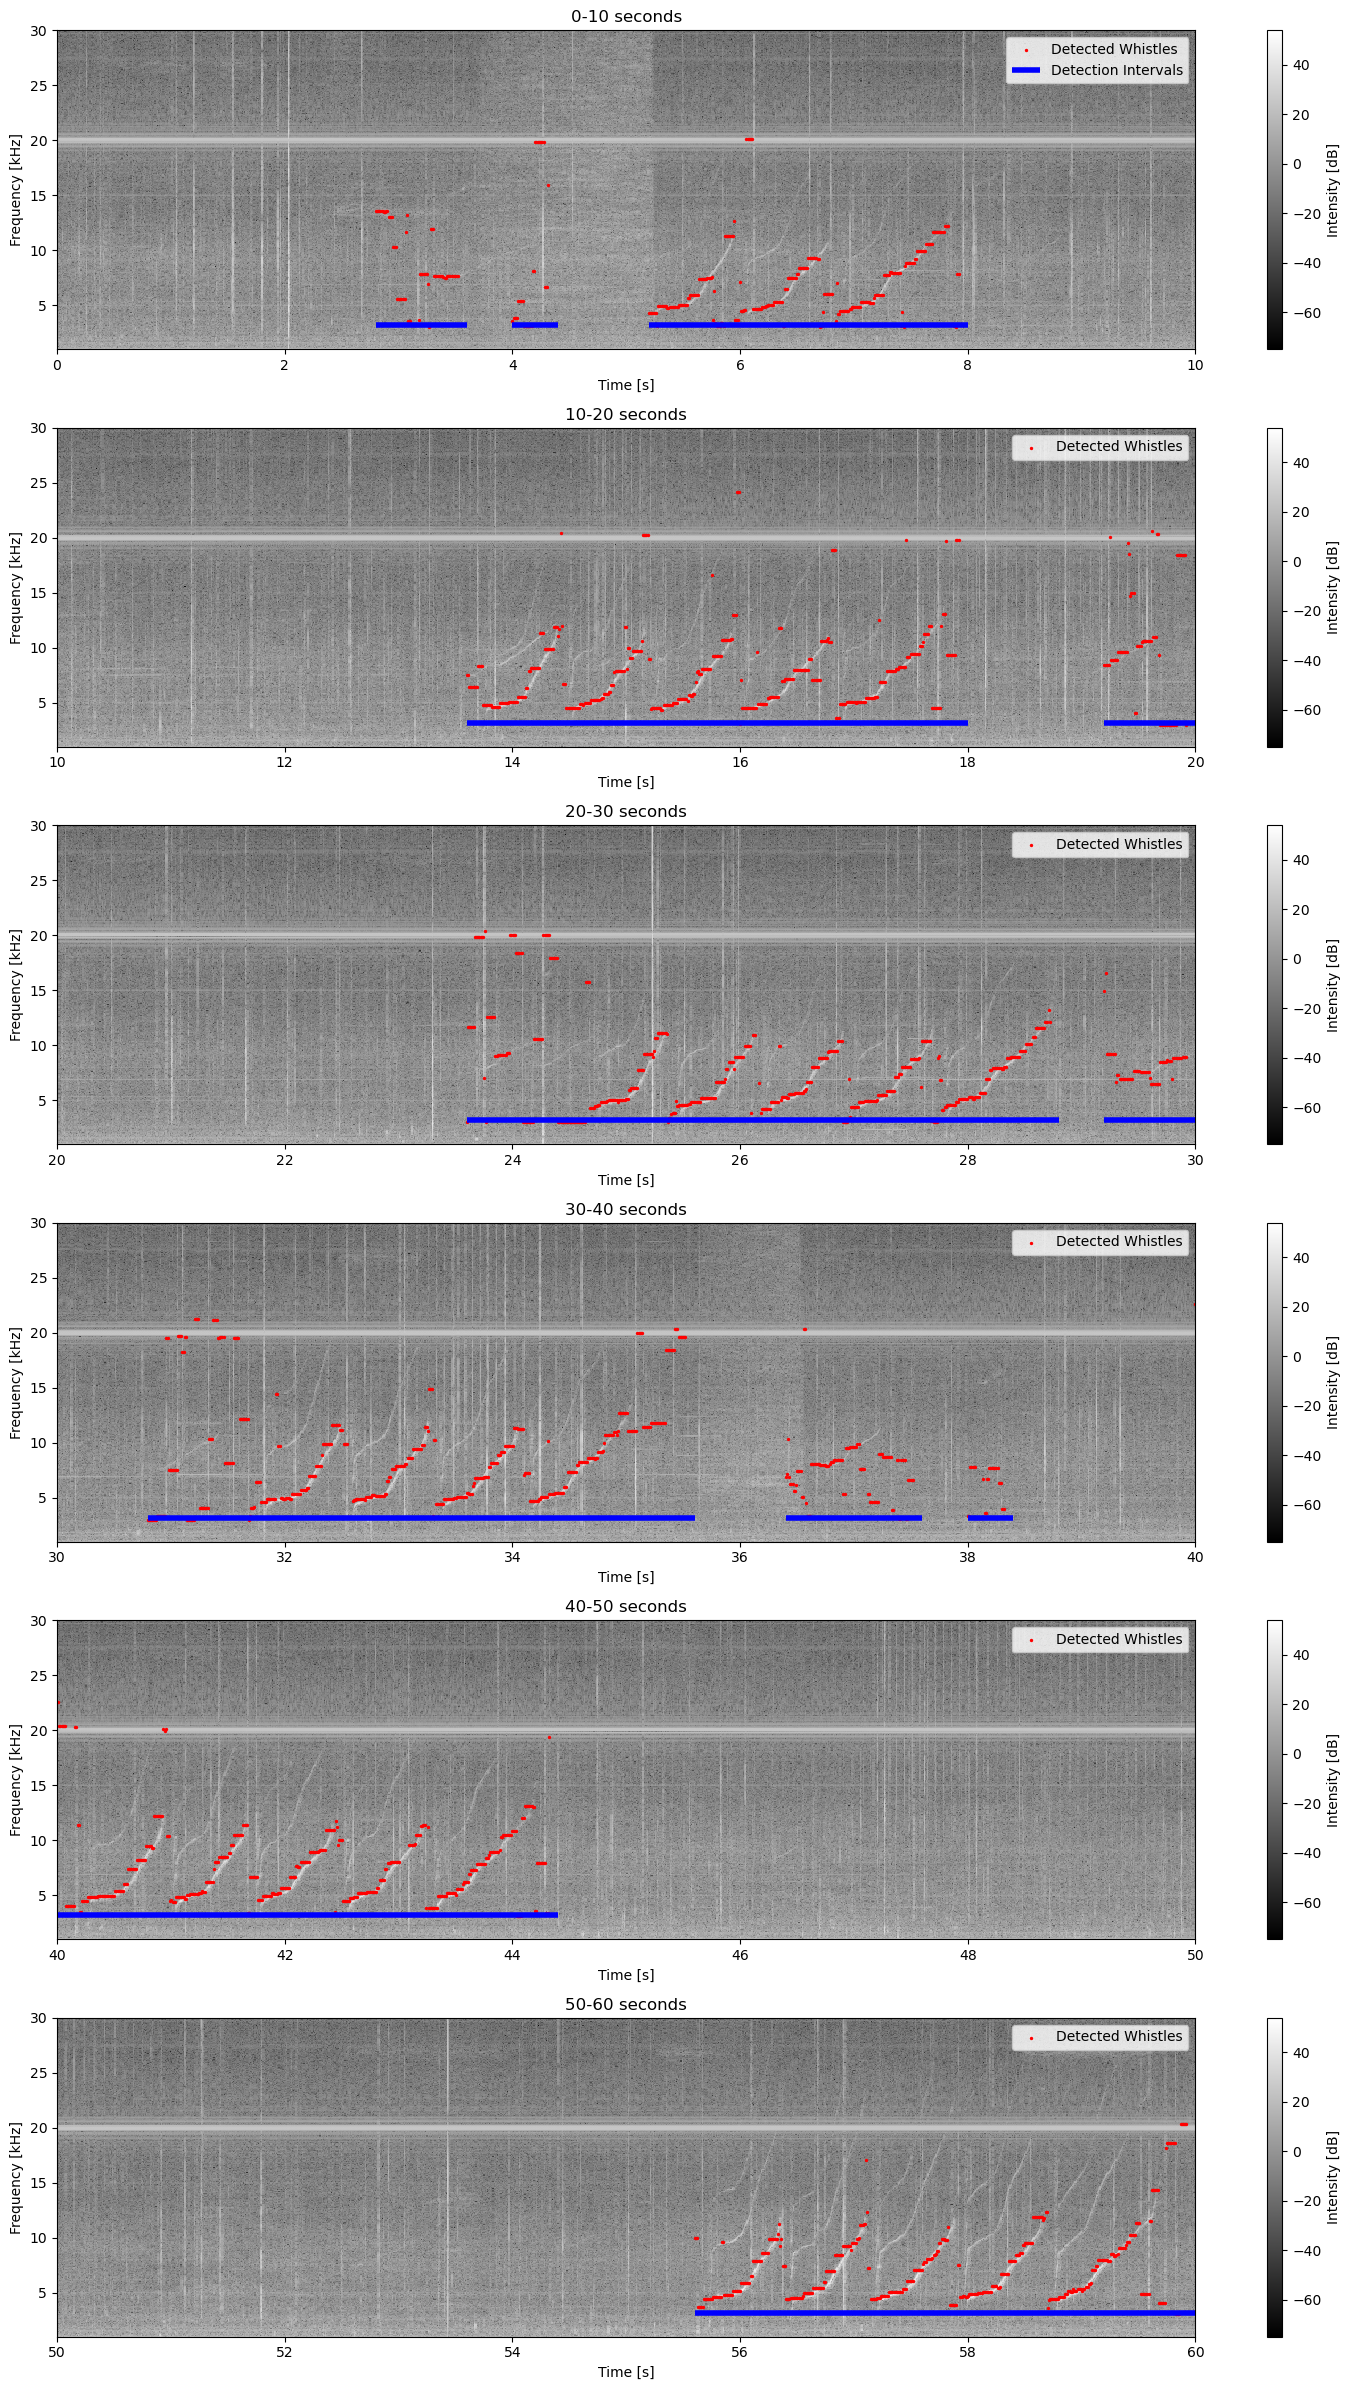

In [8]:
# Get the spectrogram for visualization
specgram, freqs, times = wav_to_spec(
    audio_path,
    stride_ms=10.0,
    window_ms=20.0,
    max_freq=30000,
    min_freq=1000
)

#specgram = spectral_subtraction(specgram, 2)

# Create a figure with 6 subplots (one for every 10 seconds)
plt.figure(figsize=(15, 24))
for i in range(6):
    ax = plt.subplot(6, 1, i+1)
    
    # Calculate time range for this subplot
    start_time = i * 10
    end_time = (i + 1) * 10
    
    # Plot spectrogram
    im = ax.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
    plt.colorbar(im, ax=ax, label='Intensity [dB]')
    
    # Plot vectorized whistles
    mask = (wht >= start_time) & (wht <= end_time)
    ax.scatter(wht[mask], whf[mask]/1000, c='r', s=2, label='Detected Whistles')
    
    # Add detection intervals
    for _, row in detections_df.iterrows():
        start_time = row['initial_point']
        end_time = row['finish_point']
        if start_time >= i * 10 and end_time <= (i + 1) * 10:  # Only plot intervals within this 10-second range
            ax.hlines(y=3.2, xmin=start_time, xmax=end_time, colors='blue', linewidth=4,
                      label='Detection Intervals' if _ == 0 else "")
    
    # Customize subplot
    ax.set_ylim(1, 30)
    ax.set_xlim(i * 10, (i + 1) * 10)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_title(f'{i * 10}-{(i + 1) * 10} seconds')
    ax.legend()

plt.tight_layout()
plt.show()


The red lines show the detected whistle contours overlaid on the spectrogram. 
Each contour represents the frequency trajectory of a detected whistle over time.

In [9]:
filepath_annotation = "/users/zfne/mustun/Documents/GitHub/Dolphins/examples/templates/SW_Yosefa.mat"
annots = loadmat(filepath_annotation)
## Get frequency and time
annots_freqs = annots['whf'][0]
annots_times = annots['wht'][0]
annots_name = filepath_annotation.split('/')[-1].split('.')[0]

Distance, Norm_Distance = distance_wh_zones(wht, whf, annots_freqs, annots_times, alphas = (0.5,1.25), n_jobs=36)
Wh, _, whistles_index = Extract_Whistles(Distance, Norm_Distance, whf, wht, annots_times, annots_freqs, 
                                        annotation_name=annots_name, threshold=3500, n_jobs=36, normalized=True)

  0%|          | 0/2932 [00:00<?, ?it/s]

100%|██████████| 2932/2932 [00:00<00:00, 3140.07it/s]


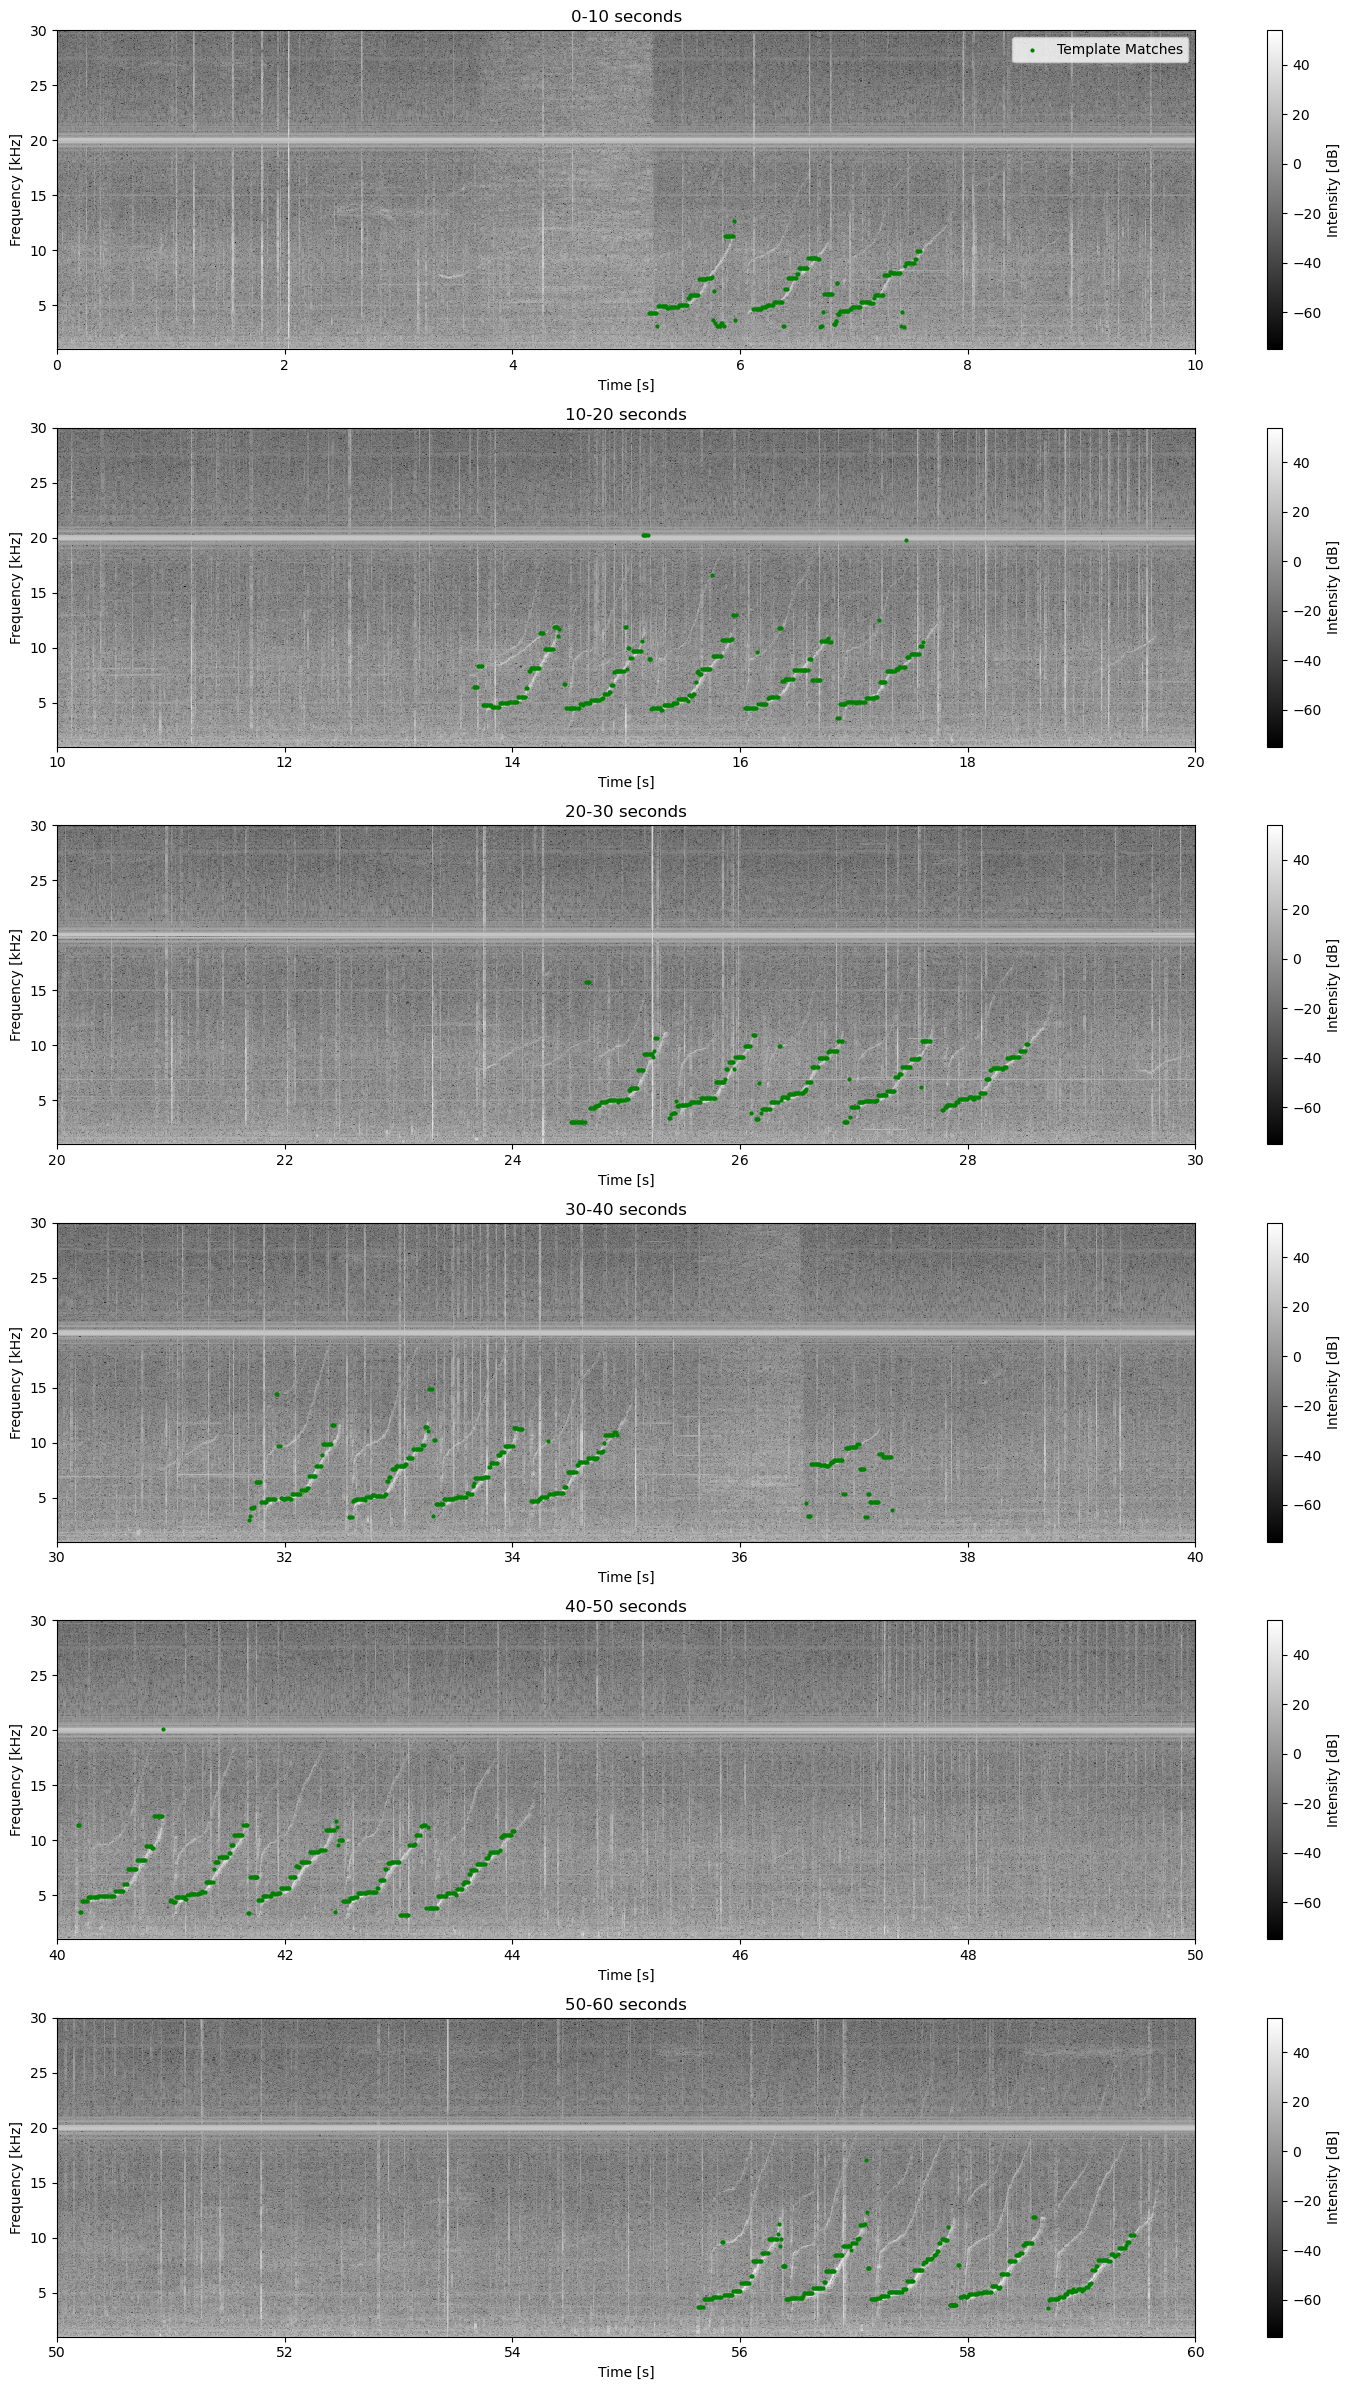

In [10]:
# Plot the extracted whistles on the spectrogram by 10-second segments
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 24))
axes = axes.flatten()

# Number of 10-second segments to plot
num_segments = min(12, int(np.ceil(np.max(wht) / 10)))

for i in range(num_segments):
    ax = axes[i]
    
    # Calculate time range for this subplot
    start_time = i * 10
    end_time = (i + 1) * 10
    
    # Plot spectrogram
    im = ax.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
    plt.colorbar(im, ax=ax, label='Intensity [dB]')
    
    # Plot original vectorized whistles
    mask = (wht >= start_time) & (wht <= end_time)
    #ax.scatter(wht[mask], whf[mask]/1000, c='r', s=2, label='Detected Whistles')
    
    # Plot extracted whistles from template matching
    for wh in Wh:
        wh_times = wh['wht']
        wh_freqs = wh['whf']
        wh_mask = (wh_times >= start_time) & (wh_times <= end_time)
        if np.any(wh_mask):
            ax.scatter(wh_times[wh_mask], wh_freqs[wh_mask]/1000, c='g', s=4, 
                      label='Template Matches' if wh is Wh[0] else "")
    
    # Customize subplot
    ax.set_ylim(1, 30)
    ax.set_xlim(i * 10, (i + 1) * 10)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_title(f'{i * 10}-{(i + 1) * 10} seconds')
    
    # Add legend but only for the first plot to avoid redundancy
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()
